In [1]:
import numpy as np
import cv2
import torch
import glob as glob

from model import create_model
from config import NUM_CLASSES, RESIZE_TO
import matplotlib.pyplot as plt

# set the computation device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# load the model and the trained weights
model = create_model(num_classes = NUM_CLASSES).to(device)

model.load_state_dict(torch.load(
    'outputs/model.pth', map_location=device
))

<All keys matched successfully>

Test instances: 20
[0.45035544 0.44631186 0.44012472 0.437354   0.42507222 0.4236504
 0.42199537 0.41960025 0.41867268 0.4158145  0.409914   0.40307483
 0.40182528 0.40089738 0.39943668 0.39809376 0.393953   0.39392716
 0.3930533  0.39277673 0.39040238 0.38894534 0.38664407 0.38621157
 0.38575655 0.382156   0.3820117  0.37936354 0.37762702 0.3769361
 0.3752259  0.37322456 0.37032965 0.36957934 0.36900783 0.36841205
 0.36790463 0.36718938 0.36542195 0.35988548 0.35840935 0.35818127
 0.35804966 0.35709146 0.35481143 0.35263672 0.35246602 0.35188848
 0.35187456 0.3507959  0.35049772 0.35027757 0.3499726  0.34849095
 0.34781587 0.34665588 0.34497568 0.34474623 0.3444386  0.34389368
 0.34360513 0.3435591  0.34032032 0.33991966 0.33923483 0.33814132
 0.3375968  0.33707148 0.3370434  0.3361594  0.33601356 0.33600703
 0.3357713  0.3354297  0.33489367 0.3341936  0.33387244 0.33302504
 0.33225876 0.33095777 0.3302984  0.3302011  0.33015054 0.33004653
 0.3296252  0.3291869  0.32834658 0.3283359  

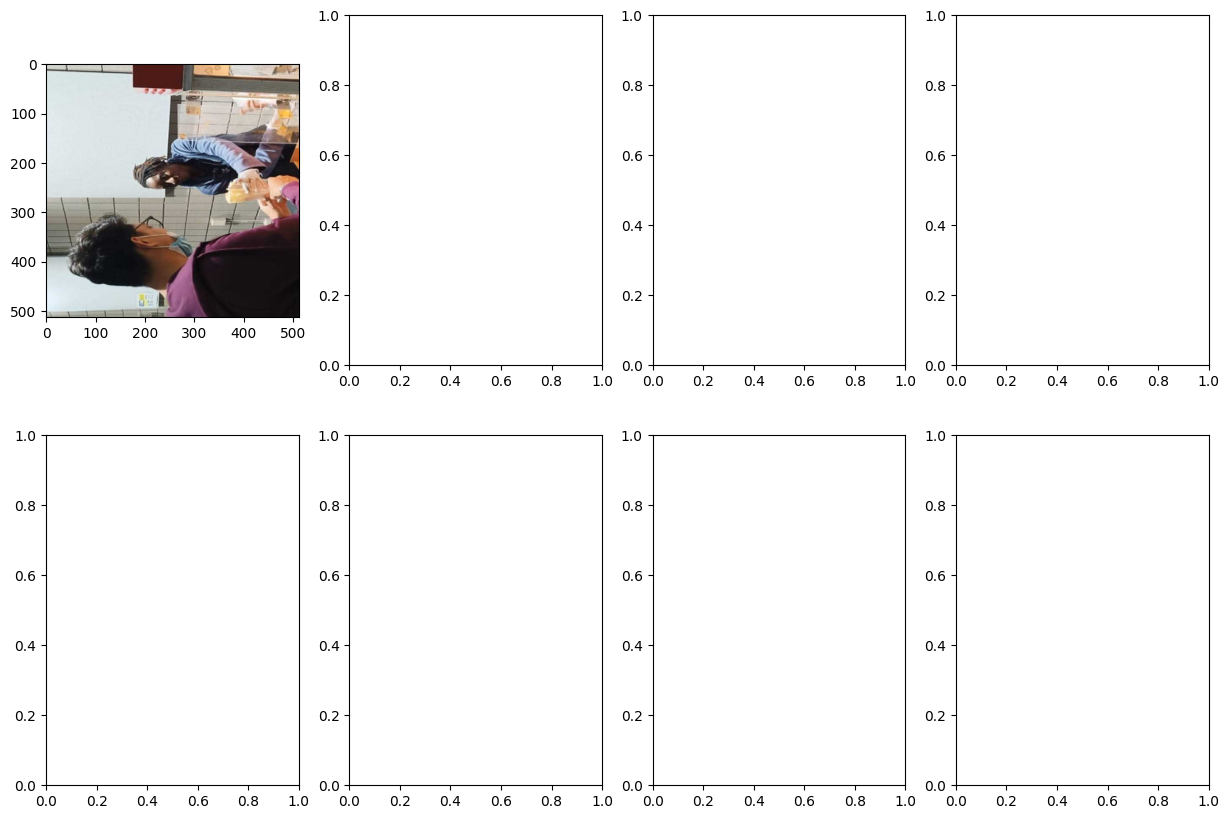

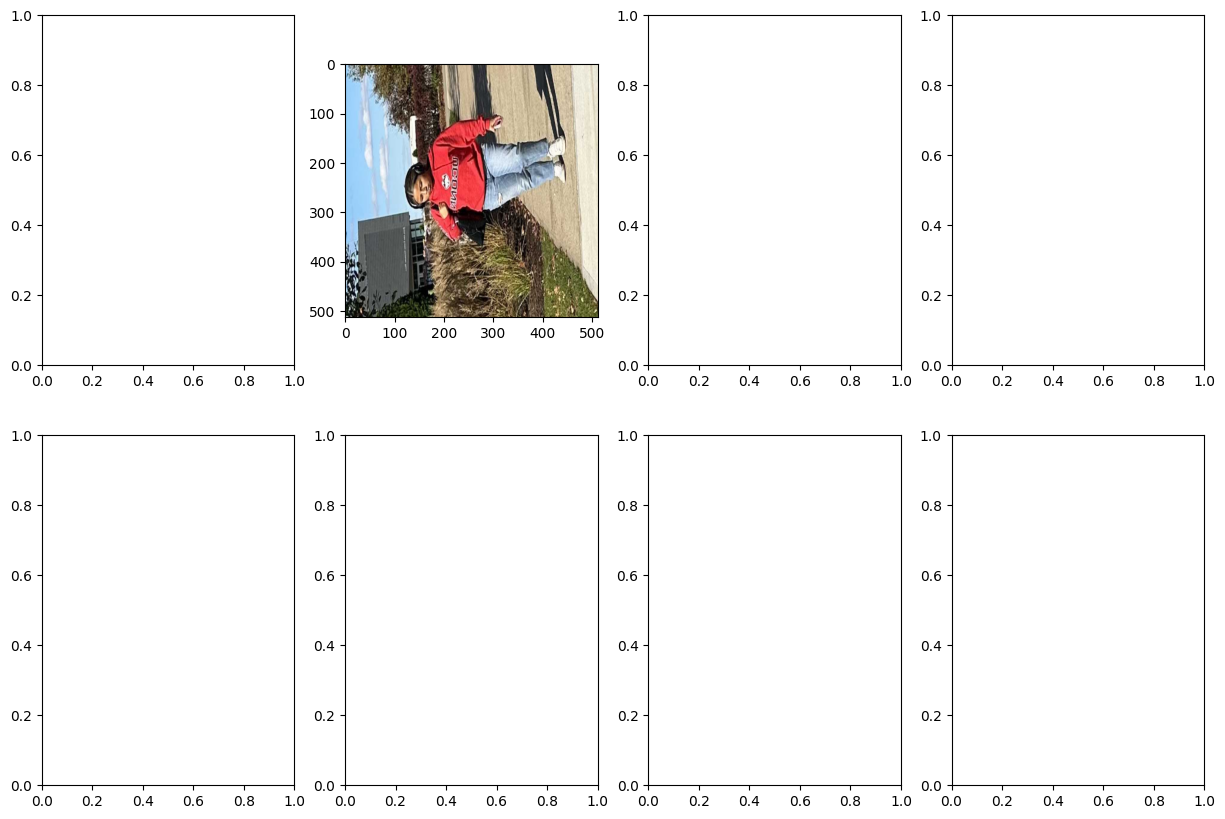

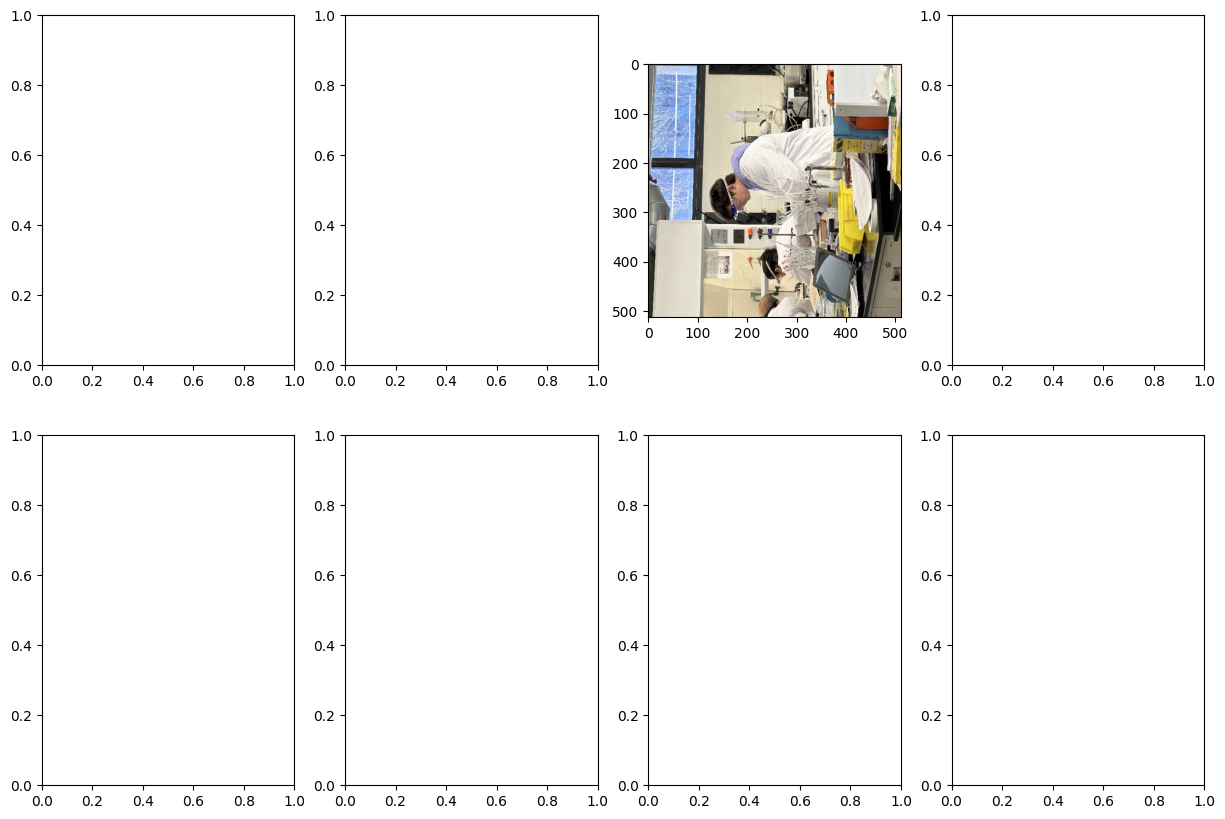

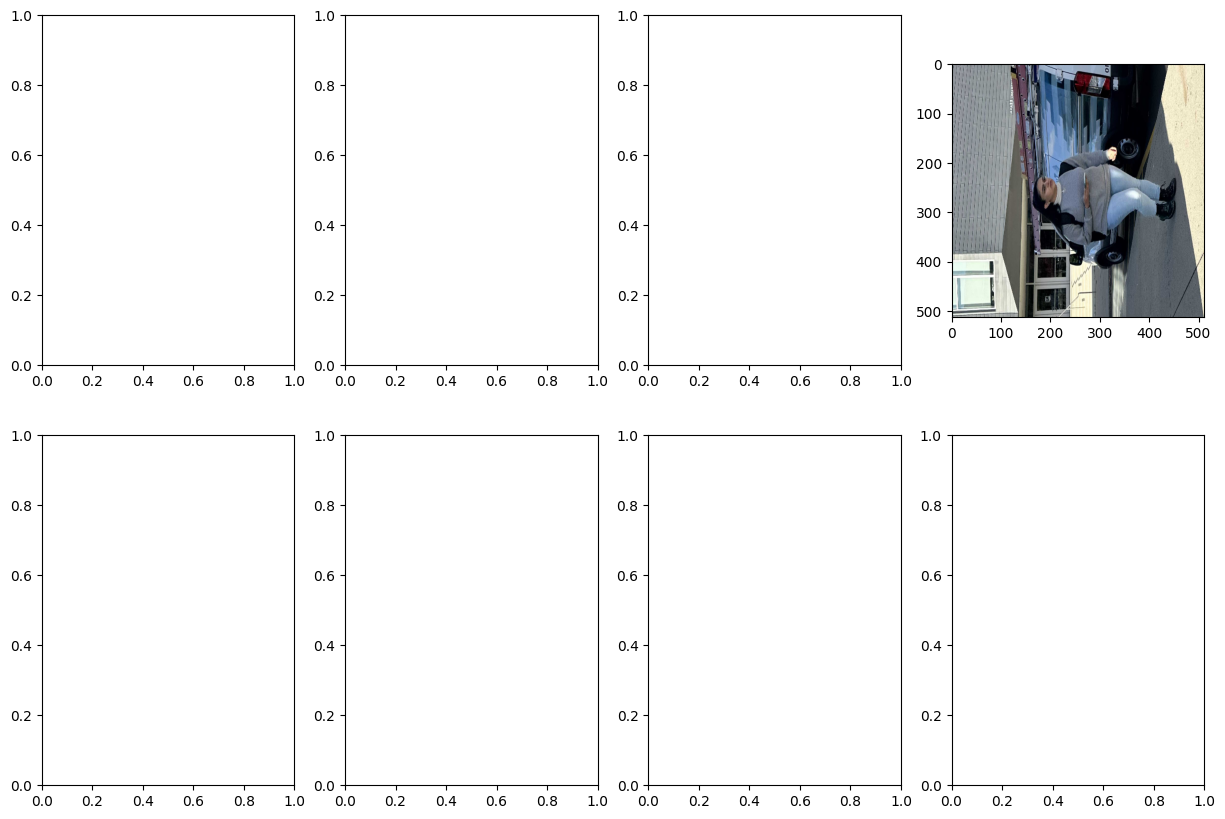

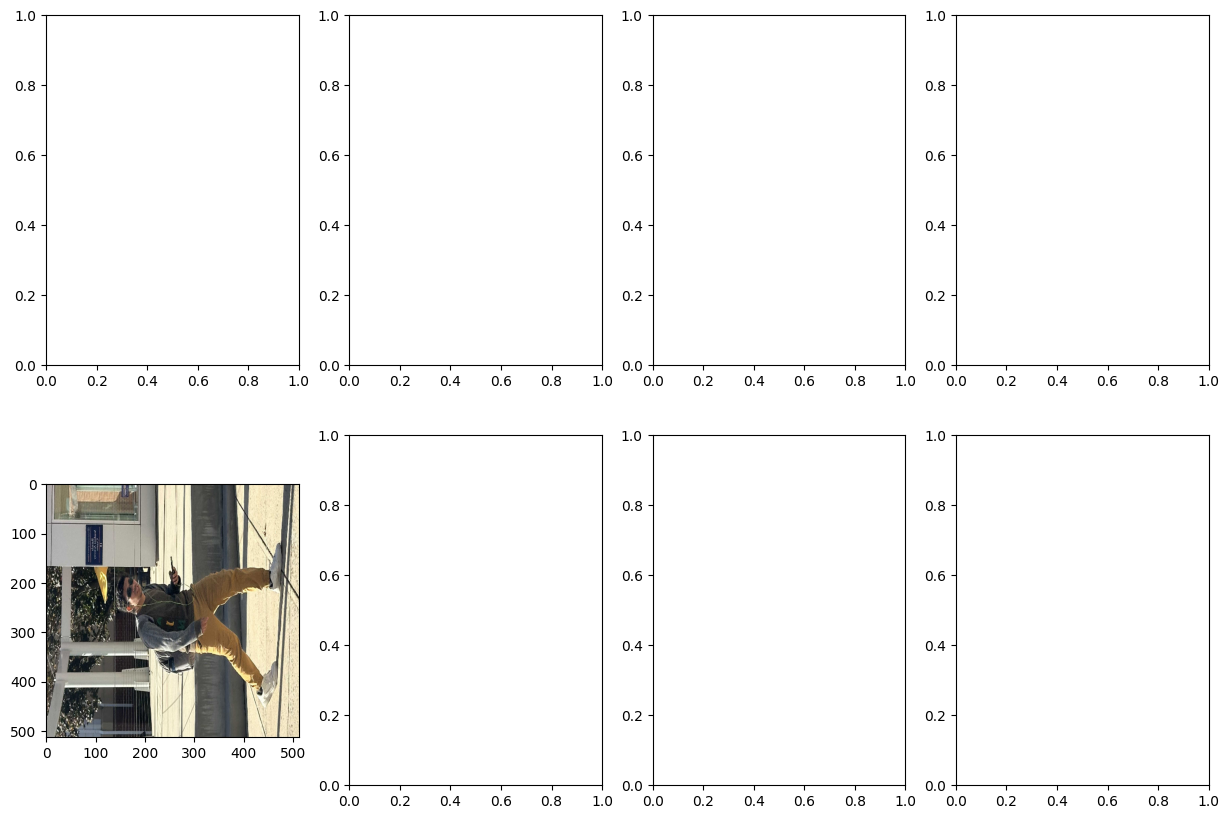

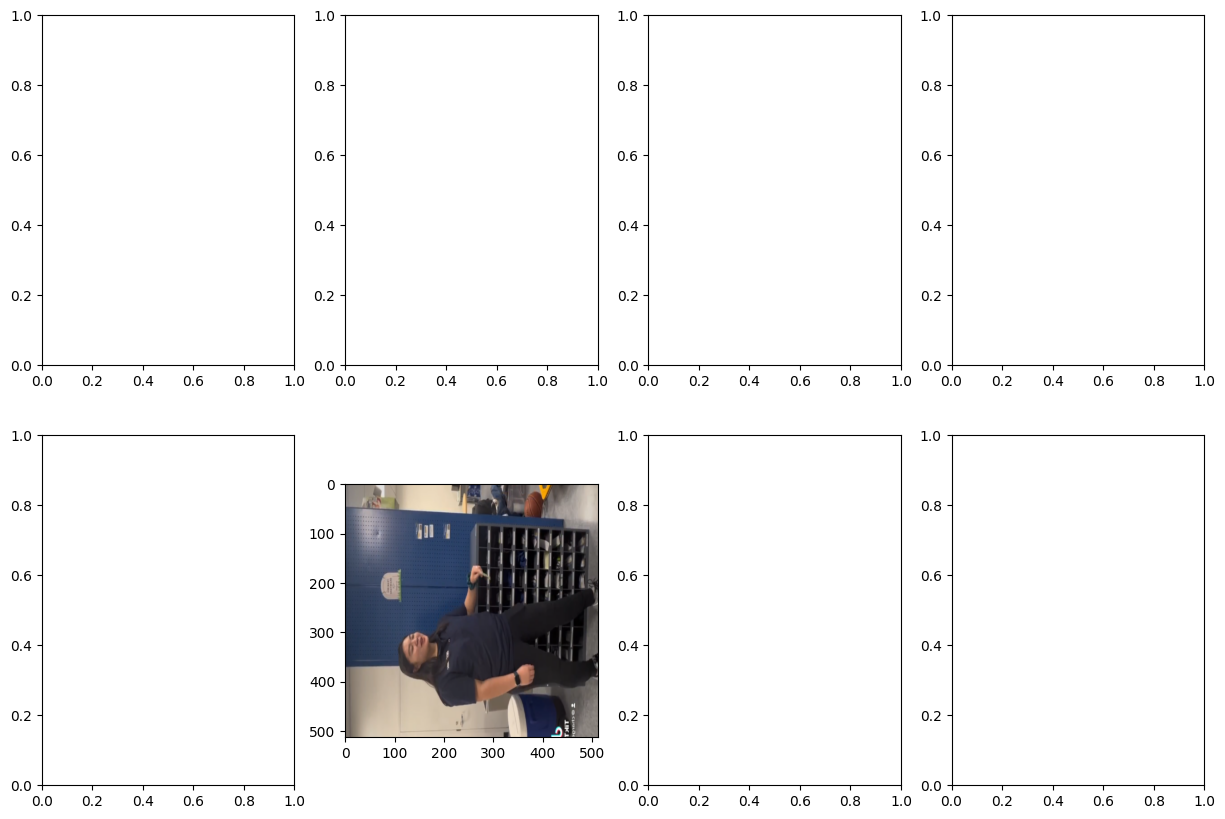

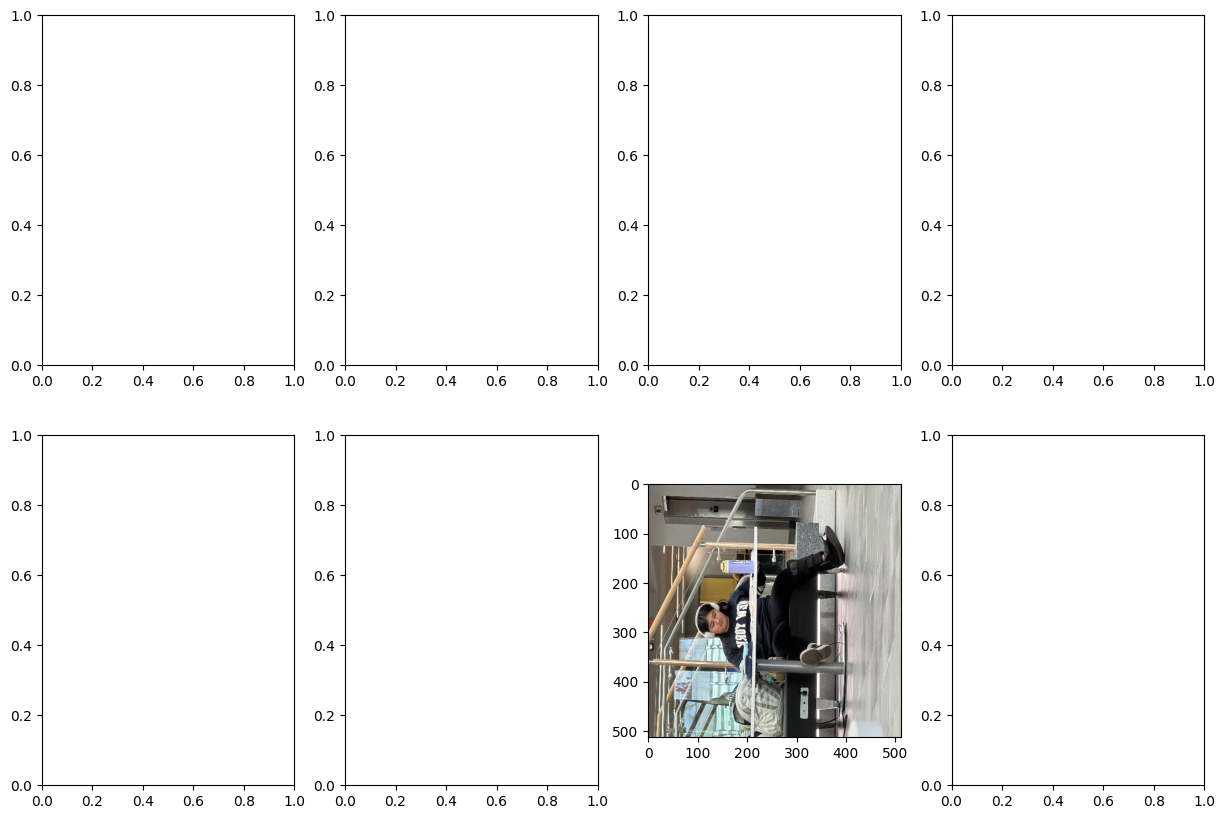

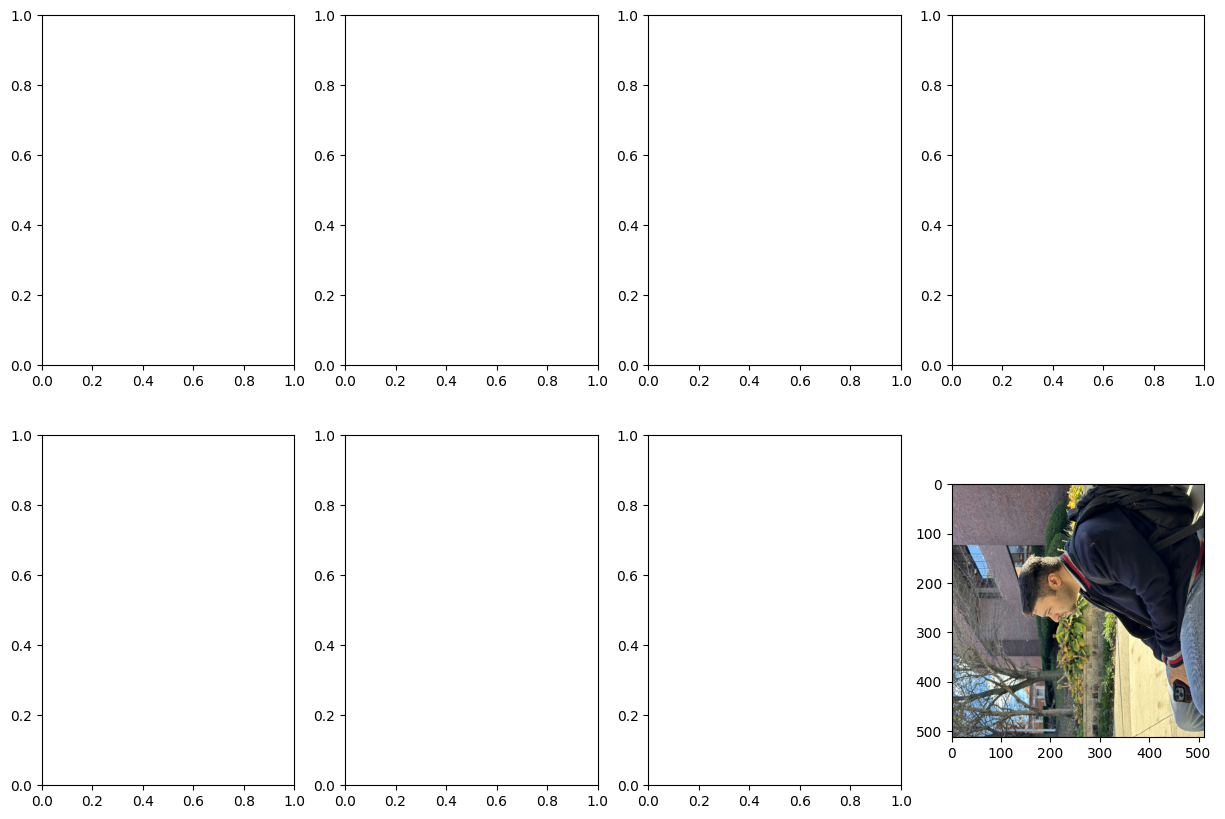

In [3]:
model.eval()

# directory where all the images are present
DIR_TEST = 'dataset/test'
test_images = glob.glob(f"{DIR_TEST}/*")
print(f"Test instances: {len(test_images)}")

test_images = test_images[10:18]

# classes: 0 index is reserved for background
CLASSES = [
    'student','Security', 'Staff', 'Facility Worker','Food Service worker'
]

# define the detection threshold...
# ... any detection having score below this will be discarded
# detection_threshold = 0.8

for i in range(len(test_images)):
    # get the image file name for saving output later on
    image_name = test_images[i].split('/')[-1].split('.')[0]
    image = cv2.imread(test_images[i])
    orig_image = image.copy()
    # BGR to RGB
    image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB).astype(np.float32)
    # resize to the model input size
    image = cv2.resize(image, (RESIZE_TO, RESIZE_TO))
    # make the pixel range between 0 and 1
    image /= 255.0
    # bring color channels to front
    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    # convert to tensor
    image = torch.tensor(image, dtype=torch.float).cuda()
    # add batch dimension
    image = torch.unsqueeze(image, 0)
    with torch.no_grad():
        outputs = model(image)
    
    # load all detection to CPU for further operations
    outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
    # carry further only if there are detected boxes
    if len(outputs[0]['boxes']) != 0:
        boxes = outputs[0]['boxes'].data.numpy()
        scores = outputs[0]['scores'].data.numpy()
        print(scores)
        # filter out boxes according to `detection_threshold`
        boxes = boxes[scores >= 0.6].astype(np.int32)
        draw_boxes = boxes.copy()
        # get all the predicited class names
        pred_classes = [CLASSES[i] for i in outputs[0]['labels'].cpu().numpy()]

        fig, axs = plt.subplots(2, 4, figsize=(15, 10))
        axs = axs.ravel()
        
        image = image.permute(0, 3, 2, 1).cpu().numpy()
        image = image.squeeze()
        axs[i].imshow(image)
        # draw the bounding boxes and write the class name on top of it
        for j, box in enumerate(boxes):
            x1, y1, x2, y2 = box
            rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color='red')
            axs[i].add_patch(rect)
            axs[i].text(x1, y1, pred_classes[j], fontsize=12, color='red')